### Import lib.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import tensorflow as tf 
import tensorflow_datasets as tfds

/opt/anaconda3/envs/py3-TF.0/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Import Img.

In [2]:
import os
from PIL import Image

def load_test_images(folder_path):
    test_images = []
    test_filenames = []
    for file in os.listdir(folder_path):
        if file.endswith(( ".jpg")): 
            img_path = os.path.join(folder_path, file)
            img = Image.open(img_path) 
            img = tf.image.resize(img, [128, 128])
            img = img / 255.0
            test_images.append(img)
            test_filenames.append(file)
    return test_images, test_filenames

train_images, train_filenames = load_test_images("crop_part1")

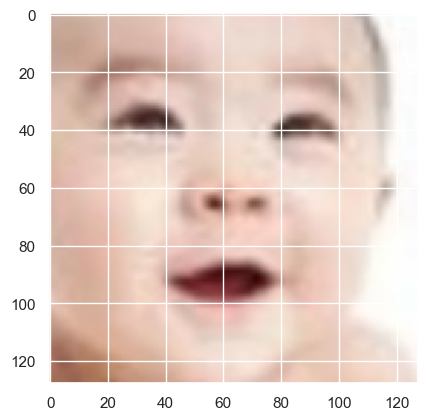

In [3]:
img = train_images[7030]
plt.imshow(img.numpy())
plt.show()

In [4]:
train_filenames = [ i.split("_") for i in (train_filenames)]
train_gender = [ int(i[1]) for i in (train_filenames)]

In [5]:
idx = train_gender.index(3)
train_images.pop(idx)
train_gender.pop(idx)

3

In [6]:
dataset = tf.data.Dataset.from_tensor_slices((train_images, train_gender))

### train_test_val split 

In [7]:
dataset = dataset.shuffle(tf.cast(len(train_gender),tf.int64))
num_test = tf.cast(0.01*len(train_images) , tf.int64)
test_data = dataset.take(num_test)
dataset = dataset.skip(num_test)
num_val = tf.cast(0.1*len(train_images) , tf.int64)
val_data = dataset.take(num_val)
train_data = dataset.skip(num_val)

In [8]:
batch_size = 32
train_data = train_data.batch(batch_size)
val_data = val_data.batch(num_val)
test_data = test_data.batch(num_test)

In [9]:
val_inputs , val_targets = next(iter(val_data))

### Model

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32 , (3,3), activation="relu", input_shape =(128,128,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64 , (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128 , (3,3), activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128 , activation="relu"),
    tf.keras.layers.Dense(64 , activation="relu"),
    tf.keras.layers.Dense(2 , activation="softmax"),
])

/opt/anaconda3/envs/py3-TF.0/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# # Define a learning rate schedule
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=0.0008, 
#     decay_steps=100,
#     decay_rate=0.96,           
#     staircase=True               
# )

# # Use it in your optimizer
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [12]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',   # 👈 track validation accuracy
    mode='max',               # 👈 because higher accuracy is better
    factor=0.5,               # reduce LR by this factor (e.g., LR = LR * 0.5)
    patience=2,               # wait for 3 epochs before reducing
    min_lr=1e-6,              # do not go below this LR
    verbose=1
)
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)

In [13]:
model.compile(optimizer= optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

### Train

In [14]:
num_epoch = 20
model.fit(train_data , epochs = num_epoch ,validation_data=(val_inputs,val_targets) ,verbose=2 ,callbacks=[reduce_lr])

Epoch 1/20
273/273 - 38s - 138ms/step - accuracy: 0.6989 - loss: 0.5994 - val_accuracy: 0.7871 - val_loss: 0.4377 - learning_rate: 1.0000e-03
Epoch 2/20
273/273 - 38s - 141ms/step - accuracy: 0.7894 - loss: 0.4361 - val_accuracy: 0.7533 - val_loss: 0.4708 - learning_rate: 1.0000e-03
Epoch 3/20
273/273 - 41s - 149ms/step - accuracy: 0.8199 - loss: 0.3708 - val_accuracy: 0.8506 - val_loss: 0.3009 - learning_rate: 1.0000e-03
Epoch 4/20
273/273 - 41s - 151ms/step - accuracy: 0.8433 - loss: 0.3286 - val_accuracy: 0.8925 - val_loss: 0.2527 - learning_rate: 1.0000e-03
Epoch 5/20
273/273 - 41s - 149ms/step - accuracy: 0.8588 - loss: 0.3000 - val_accuracy: 0.8843 - val_loss: 0.2477 - learning_rate: 1.0000e-03
Epoch 6/20
273/273 - 41s - 149ms/step - accuracy: 0.8850 - loss: 0.2494 - val_accuracy: 0.9069 - val_loss: 0.2284 - learning_rate: 1.0000e-03
Epoch 7/20
273/273 - 42s - 155ms/step - accuracy: 0.9107 - loss: 0.2066 - val_accuracy: 0.9386 - val_loss: 0.1561 - learning_rate: 1.0000e-03
Epoch 


### Test and evaluate

In [15]:
test_loss , test_acc = model.evaluate(test_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 837ms/step - accuracy: 1.0000 - loss: 0.0098


In [16]:
print(f"Test loss is {test_loss} and Test accuracy is {test_acc}")

Test loss is 0.00980549119412899 and Test accuracy is 1.0


In [17]:
test_img , test_lab = next(iter(test_data))

In [18]:
pred = np.array(model.predict(test_img))
predictions = np.argmax(pred , axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [19]:
test_lab = np.array(test_lab)

<Axes: >

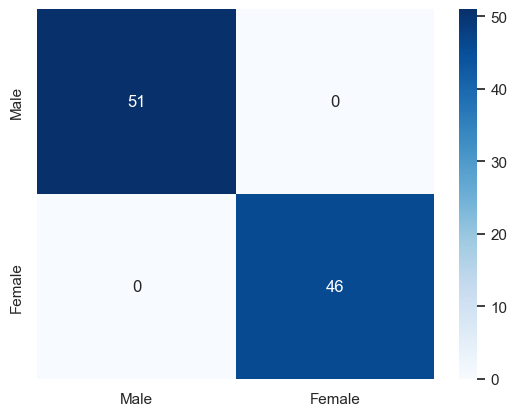

In [20]:
from sklearn.metrics import confusion_matrix
class_names =["Male", "Female"]
cf_matrix = confusion_matrix(test_lab, predictions)
sns.heatmap(cf_matrix, annot=True ,cmap='Blues',xticklabels=class_names, yticklabels=class_names)

### Saving the model 


In [21]:
import pickle 
with open ('GenderRecoginition', 'wb') as file :
	pickle.dump( model , file )


### Module Versions 

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import PIL

print("numpy==", np.__version__)
print("pandas==", pd.__version__)
print("matplotlib==", matplotlib.__version__)
print("seaborn==", sns.__version__)
print("tensorflow==", tf.__version__)
print("tensorflow-datasets==", tfds.__version__)
print("Pillow==", PIL.__version__)

numpy== 2.0.2
pandas== 2.3.0+4.g1dfc98e16a
matplotlib== 3.9.4
seaborn== 0.13.2
tensorflow== 2.19.0
tensorflow-datasets== 4.9.3
Pillow== 11.3.0


/opt/anaconda3/envs/py3-TF.0/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
!python --version

Python 3.12.7
